## Student Name : Rakesh Paul
## Student ID : 22271872

### Import Python Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#### Load the dataset

In [2]:
df = pd.read_csv("./loans_train_prepared.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


In [3]:
df.head()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0    0.000000         1.084523    1.058140              0.75               1   
1    0.333333         0.925883    1.047319              0.75               1   
2    0.000000         0.683858    0.635920              0.75               1   
3    0.000000         0.608992    1.002824              0.75               1   
4    0.000000         1.101869    1.115650              0.75               1   

   Gender_Male  Gender_nan  Married_Yes  Married_nan  Self_Employed_Yes  \
0            1           0            0            0                  0   
1            1           0            1            0                  0   
2            1           0            1            0                  1   
3            1           0            1            0                  0   
4            1           0            0            0                  0   

   Self_Employed_nan  Education_Not Graduate  Property_Area_Semiurban  \
0                  0                       0                        0   
1                  0                       0                        0   
2                  0                       0                        0   
3                  0                       1                        0   
4                  0                       0                        0   

   Property_Area_Urban  Loan_Status_Y  TotalIncome  
0                    1              1     0.841086  
1                    0              0     0.871711  
2                    1              1     0.385189  
3                    1              1     0.717012  
4                    1              1     0.860305

In [4]:
df.tail()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
609    0.000000         0.666409    0.676143             0.750   
610    1.000000         0.858916    0.395858             0.375   
611    0.333333         1.313719    1.566110             0.750   
612    0.666667         1.267616    1.325676             0.750   
613    0.000000         0.925883    1.074155             0.750   

     Credit_History  Gender_Male  Gender_nan  Married_Yes  Married_nan  \
609               1            0           0            0            0   
610               1            1           0            1            0   
611               1            1           0            1            0   
612               1            1           0            1            0   
613               0            0           0            0            0   

     Self_Employed_Yes  Self_Employed_nan  Education_Not Graduate  \
609                  0                  0                       0   
610                  0                  0                       0   
611                  0                  0                       0   
612                  0                  0                       0   
613                  1                  0                       0   

     Property_Area_Semiurban  Property_Area_Urban  Loan_Status_Y  TotalIncome  
609                        0                    0              1     0.364708  
610                        0                    0              1     0.587496  
611                        0                    1              1     1.116075  
612                        0                    1              1     1.042256  
613                        1                    0              0     0.663523

### Rescale the Data
Dataset is already prepared for ML and there is no need to rescale it again.

## Task 2

### Plot Sum of Squared distance

In [5]:
def SSD(data, max_clusters=10):
    sum_of_squared_distance = []

    k_range = range(1, max_clusters + 1)

    for k in k_range:
        clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42).fit(data)

        sum_of_squared_distance.append(clustered_data_sklearn.inertia_)
    print(sum_of_squared_distance)
    # Plot the results
    plt.plot(range(1, max_clusters + 1), sum_of_squared_distance, '-o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances')
    plt.show()
    
    return sum_of_squared_distance

C:\Users\sneha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


[1316.9759347582847, 1127.6180114587287, 1005.8528230130036, 914.0528805309796, 847.8533171624578, 798.7856198595143, 766.221641727334, 732.1911761961583, 700.0050501433855, 677.5705843424678]


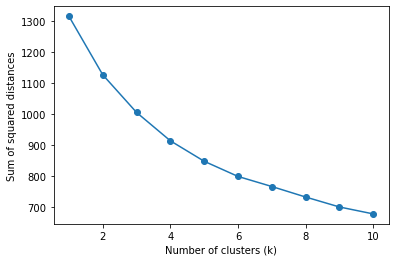

In [6]:
max_clusters = 10
sum_of_squared_distance = SSD(data, max_clusters)

### Best K value

#### Elbow method
The goal is to find the elbow point where the increase in within-cluster sum of squares (WCSS) begins to level off (the curve starts to form an elbow shape). This is the point where the marginal gain of adding more clusters diminishes significantly, and is often used as a heuristic for determining the optimal number of clusters. 

In [7]:
def Elbow(sum_of_squared_distance):
    # Calculate the first and second derivatives of the SSD values
    derivative_1 = np.diff(sum_of_squared_distance)
    derivative_2 = np.diff(derivative_1)

    # Find the elbow point (by taking index where second order derivative is closest to 0)
    best_k_elbow = np.argmin(derivative_2) + 2

    print("Optimal number of elbow cluster(k) = ", best_k_elbow)

    return best_k_elbow

In [8]:
best_k_elbow = Elbow(sum_of_squared_distance)

Optimal number of elbow cluster(k) =  7


#### Silhouette method
Silhouette method is used to compute optimal number of clusters for given data set.
Silhouette score ranges from -1 to 1, where,
- score of 1 indicates that the data point is very similar to its own cluster and very dissimilar to other clusters
- Score of -1 indicates the opposite.

The algorithm relies on random initialization of centroids. Therefore, ìt is good to run multiple times and get an average score for each k value in the range.

In [9]:
def SilhouetteCalc(data, max_k, num_runs=10):
    silhouette_scores = []
    k_range = range(2, max_k+1)
    for k in k_range:
        scores=[]
        for i in range(num_runs):
            kmeans = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300, random_state = i).fit(data)
            scores.append(silhouette_score(data, kmeans.labels_))
        
        score_average = np.mean(scores)
        silhouette_scores.append(score_average)
           
    # Select the number of clusters with the highest silhouette score
    best_k = np.argmax(silhouette_scores) + 2
    
    # Plot the silhouette scores
    plt.plot(k_range, silhouette_scores)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('KMeans Silhouette Score')
       
    return best_k, silhouette_scores   

Optimal number of silhouette cluster(k) =  10


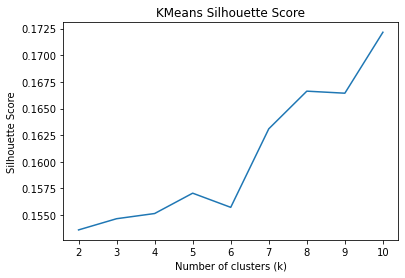

In [10]:
# Find optimal k value
best_k_Silhouette, silhouette_scores = SilhouetteCalc(data, max_clusters)
print("Optimal number of silhouette cluster(k) = ", best_k_Silhouette)

### Create clusters for the best values of k and visualize
#### Best K value
The elbow method suggested optimal cluster k = 7, whereas Silhouette method suggests optimal number of clusters (k = 10). Findind the optimal k value is performed by chosing k value having the highest Silhouette score within the range of elbow point. 

In [11]:
def BestNumberOfCluster(best_k_elbow, silhouette_scores):
    best_k = None
    best_silhouette = -1
    for k in range(best_k_elbow - 1, best_k_elbow + 2):
        silhouette = silhouette_scores[k - 2]
        if silhouette > best_silhouette:
            best_k = k
            best_silhouette = silhouette

    print("Optimal number of cluster(k) = ", best_k)
    print("Best silhouette score = ", best_silhouette)
    
    return best_k, best_silhouette

In [12]:
best_k, best_silhouette = BestNumberOfCluster(best_k_elbow, silhouette_scores)

Optimal number of cluster(k) =  8
Best silhouette score =  0.1666309340828529


#### Scatterplot Function (to be used below for visualising a clustering)
The function `clustering_scatterplot()` creates the 2D scatter plot of the clustered dataset.

In [13]:
colors = np.array(['orange', 'yellow', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple', 'c', 'm'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    plt.figure(figsize=(16, 8))
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

#### Append center of clusters

In [14]:
# Kmeans using optimal k
clustered_data_kmeans = cluster.KMeans(n_clusters=best_k, n_init=10, max_iter=300).fit(data)

# append cluster centers to the dataset
data_and_centers = np.r_[data, clustered_data_kmeans.cluster_centers_]

#### Apply Manifold-learning techniques to project the data set to a 2D space
##### Apply multi-dimensional scaling (MDS)

transformation complete


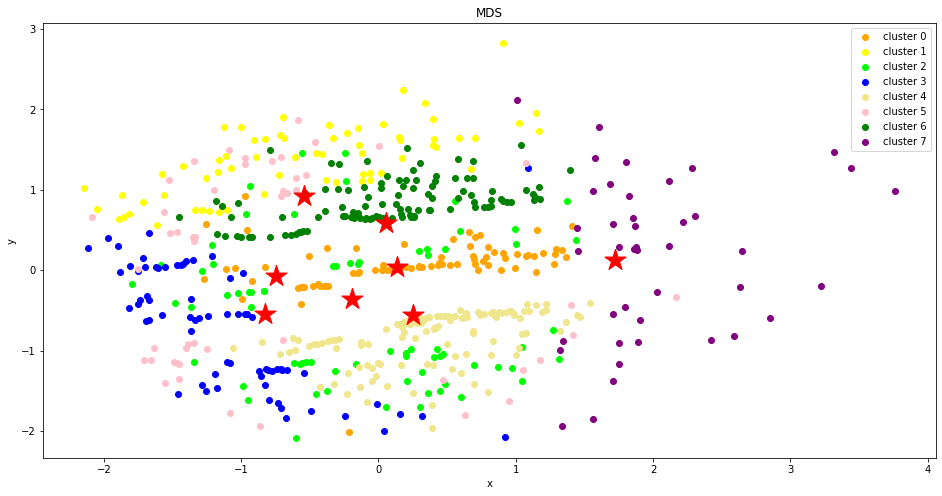

In [15]:
# Project the data and the k-Means cluster centers to 2D.
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

# Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.
clustering_scatterplot(points=XYcoordinates[:-best_k,:], 
                       labels=clustered_data_kmeans.labels_, 
                       centers=XYcoordinates[-best_k:,:], 
                       title='MDS')

#### Apply t-SNE

C:\Users\sneha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


transformation complete


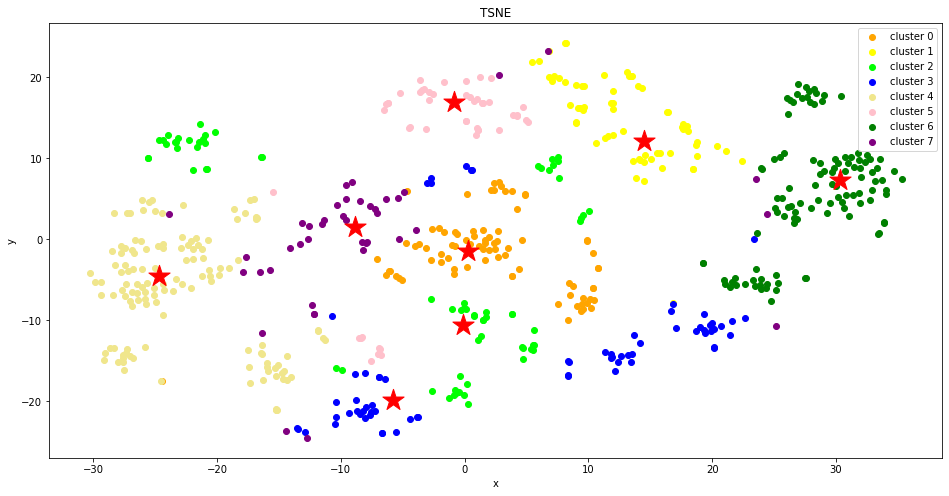

In [16]:
# Project both the data and the k-Means cluster centers to 2D.
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

# Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.
clustering_scatterplot(points=XYcoordinates[:-best_k,:], 
                       labels=clustered_data_kmeans.labels_,
                       centers=XYcoordinates[-best_k:,:], 
                       title='TSNE')

#### Apply isomap

transformation complete


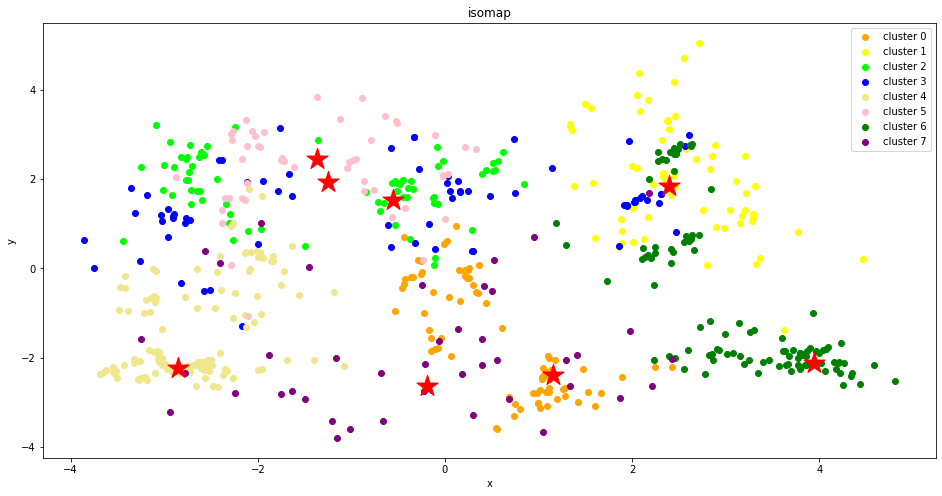

In [17]:
# Project both the data and the k-Means cluster centers to 2D.
XYcoordinates = manifold.Isomap(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

# Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.
clustering_scatterplot(points=XYcoordinates[:-best_k,:], 
                       labels=clustered_data_kmeans.labels_,
                       centers=XYcoordinates[-best_k:,:], 
                       title='isomap')

#### Add the cluster labels as an extra column in the original dataframe

In [18]:
df['cluster_kmeans'] = pd.Series(clustered_data_kmeans.labels_, index=df.index)

In [19]:
df.groupby('cluster_kmeans').mean()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
cluster_kmeans                                                              
0                 0.235772         0.867643    1.102183          0.707012   
1                 0.229167         0.814354    1.031839          0.710938   
2                 0.319249         0.768481    0.965117          0.715845   
3                 0.085714         0.851950    0.915402          0.736786   
4                 0.220472         0.858022    1.084516          0.727756   
5                 0.299320         0.806427    1.053271          0.724490   
6                 0.293578         0.867375    1.016668          0.680734   
7                 0.357143         1.959375    1.705278          0.714286   

                Credit_History  Gender_Male  Gender_nan  Married_Yes  \
cluster_kmeans                                                         
0                     0.975610     0.987805    0.012195     0.731707   
1                     0.546875     0.812500    0.000000     0.593750   
2                     0.985915     0.929577    0.000000     0.676056   
3                     0.985714     0.000000    0.042857     0.042857   
4                     0.992126     0.881890    0.007874     0.795276   
5                     0.000000     0.775510    0.061224     0.673469   
6                     0.990826     0.981651    0.000000     0.788991   
7                     0.880952     0.785714    0.119048     0.690476   

                Married_nan  Self_Employed_Yes  Self_Employed_nan  \
cluster_kmeans                                                      
0                  0.000000           0.146341           0.060976   
1                  0.000000           0.140625           0.062500   
2                  0.000000           0.126761           0.070423   
3                  0.014286           0.114286           0.071429   
4                  0.007874           0.110236           0.031496   
5                  0.000000           0.122449           0.020408   
6                  0.009174           0.073394           0.055046   
7                  0.000000           0.380952           0.047619   

                Education_Not Graduate  Property_Area_Semiurban  \
cluster_kmeans                                                    
0                             0.000000                 0.000000   
1                             0.296875                 0.000000   
2                             1.000000                 0.492958   
3                             0.142857                 0.414286   
4                             0.000000                 1.000000   
5                             0.265306                 0.510204   
6                             0.174312                 0.000000   
7                             0.047619                 0.404762   

                Property_Area_Urban  Loan_Status_Y  TotalIncome  
cluster_kmeans                                                   
0                          0.000000       0.817073     0.891992  
1                          1.000000       0.000000     0.830043  
2                          0.000000       0.760563     0.697852  
3                          0.271429       0.728571     0.661462  
4                          0.000000       0.897638     0.832077  
5                          0.000000       0.000000     0.737328  
6                          1.000000       1.000000     0.804963  
7                          0.238095       0.642857     1.857842

#### Derived feature for better statistics
Implement a new attribute for better interpretation of the clusters

In [20]:
df['loan_to_income_ratio'] = df['LoanAmount'] / df['TotalIncome']
df.groupby('cluster_kmeans').mean()

Dependents  ApplicantIncome  LoanAmount  Loan_Amount_Term  \
cluster_kmeans                                                              
0                 0.235772         0.867643    1.102183          0.707012   
1                 0.229167         0.814354    1.031839          0.710938   
2                 0.319249         0.768481    0.965117          0.715845   
3                 0.085714         0.851950    0.915402          0.736786   
4                 0.220472         0.858022    1.084516          0.727756   
5                 0.299320         0.806427    1.053271          0.724490   
6                 0.293578         0.867375    1.016668          0.680734   
7                 0.357143         1.959375    1.705278          0.714286   

                Credit_History  Gender_Male  Gender_nan  Married_Yes  \
cluster_kmeans                                                         
0                     0.975610     0.987805    0.012195     0.731707   
1                     0.546875     0.812500    0.000000     0.593750   
2                     0.985915     0.929577    0.000000     0.676056   
3                     0.985714     0.000000    0.042857     0.042857   
4                     0.992126     0.881890    0.007874     0.795276   
5                     0.000000     0.775510    0.061224     0.673469   
6                     0.990826     0.981651    0.000000     0.788991   
7                     0.880952     0.785714    0.119048     0.690476   

                Married_nan  Self_Employed_Yes  Self_Employed_nan  \
cluster_kmeans                                                      
0                  0.000000           0.146341           0.060976   
1                  0.000000           0.140625           0.062500   
2                  0.000000           0.126761           0.070423   
3                  0.014286           0.114286           0.071429   
4                  0.007874           0.110236           0.031496   
5                  0.000000           0.122449           0.020408   
6                  0.009174           0.073394           0.055046   
7                  0.000000           0.380952           0.047619   

                Education_Not Graduate  Property_Area_Semiurban  \
cluster_kmeans                                                    
0                             0.000000                 0.000000   
1                             0.296875                 0.000000   
2                             1.000000                 0.492958   
3                             0.142857                 0.414286   
4                             0.000000                 1.000000   
5                             0.265306                 0.510204   
6                             0.174312                 0.000000   
7                             0.047619                 0.404762   

                Property_Area_Urban  Loan_Status_Y  TotalIncome  \
cluster_kmeans                                                    
0                          0.000000       0.817073     0.891992   
1                          1.000000       0.000000     0.830043   
2                          0.000000       0.760563     0.697852   
3                          0.271429       0.728571     0.661462   
4                          0.000000       0.897638     0.832077   
5                          0.000000       0.000000     0.737328   
6                          1.000000       1.000000     0.804963   
7                          0.238095       0.642857     1.857842   

                loan_to_income_ratio  
cluster_kmeans                        
0                           1.390037  
1                           2.511022  
2                           1.480153  
3                           1.616270  
4                           1.417520  
5                           1.589756  
6                           1.345194  
7                           0.952848

### Observation

It can be seen that some clusters are scattered whereas some are dense in reduced dimension. It means, the original data is not well separable and the clustering algorithm is struggling to find distinct clusters. 

From the MDS, t-SNE and isomap manifold-learning plots of the clustered dataset, it looks like a very complex dataset with highly correlated features and not much separation among the clusters. Attributes are highly correlated and too many of them are present in the dataset. Using dimentionallity reduction techniques can result in having smaller set of uncorrelated principal components which explain most of the variance in the data.

<b> Characteristics of cluster (0 - 7) </b>: 
- Cluster quality : A Silhouette score of 0.16 is considered to be a low score. It suggests that the clustering may not be meaningful or useful for characterizing the data. 

- If we try to see the derived attribute "loan_to_income_ratio" (useful as quality of clustering is low) , we can arrive at following observation:
    - Cluster 7 : These individuals have the lowest "total loan to total income" ratio (<1). They are low risk borrower.
    - Cluster 1 : These individuals have very high "total loan to total income" ratio (>2). They are high risk borrower.
    - All other Cluster : These individuals have moderate "total loan to total income" ratio (<2). They are medium risk borrower.
- Data distribution:
    - t-SNE plot: Cluster 2 is sparse, whereas cluster 1 and 6 have tight grouping. Means, the data points in cluster 1 and 6 have lot of similarity than data points of cluster 2.
    
<b> This observation is true for this run of k-Means. If the code is executed again, k-Means may produce either different clusters or the same clusters but in a different order. </b>

In [21]:
# Drop new derived feature before proceeding further
df = df.drop("loan_to_income_ratio", axis=1)

### Further Analysis
As the different manifold learning visualizations depict, there is no clear separation of clusters found. The reason maybe because of dataset including too many correlated feature. Therefore, it may be better to apply dimension reduction before applying clustering algorithm by finding uncorrelated principal components with reduced feature set while preserving overall variance of original data.

Apply PCA before K-Means clustering and see if any better result.

#### Use PCA before applying k-means 

In [22]:
pca = PCA(n_components=2)
pca.fit(data)
transformed_data = pca.transform(data)

##### Find optimal number of clusters

C:\Users\sneha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


[477.9238409223347, 303.4104080012871, 186.00747323892685, 147.2474751588126, 114.62107001560747, 91.87324928241915, 76.54838731684596, 65.80348809253886, 55.9002507701885, 49.351077139264994]


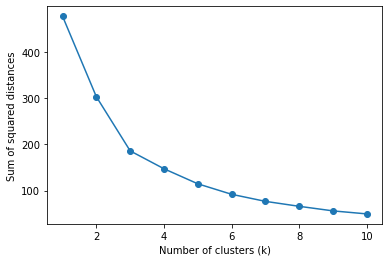

Optimal number of elbow cluster(k) =  8


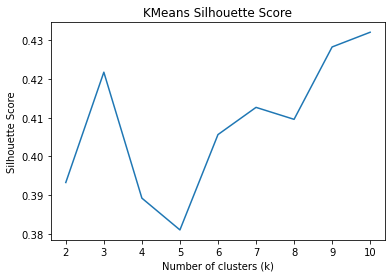

In [23]:
sum_of_squared_distance_pca = SSD(transformed_data)
best_k_elbow_pca = Elbow(sum_of_squared_distance_pca)
best_k_Silhouette_pca, silhouette_scores_pca = SilhouetteCalc(transformed_data, max_clusters)

In [24]:
best_k_pca, best_silhouette_pca = BestNumberOfCluster(best_k_elbow_pca, silhouette_scores_pca)

Optimal number of cluster(k) =  9
Best silhouette score =  0.42829063380096877


##### Calculate cluster and visualize using MDS

transformation complete


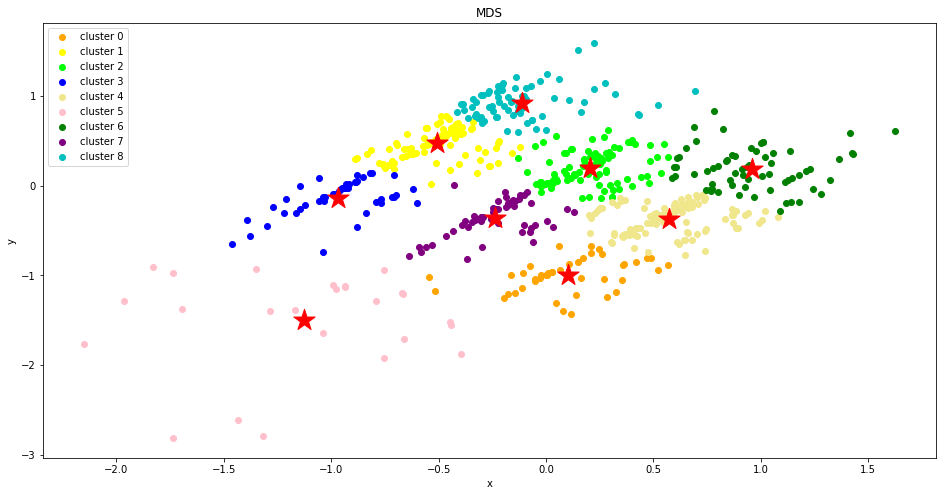

In [25]:
# Kmeans using optimal k
clustered_data_kmeans_pca = cluster.KMeans(n_clusters=best_k_pca, n_init=10, max_iter=300).fit(transformed_data)

# append cluster centers to the dataset
data_and_centers_pca = np.r_[transformed_data, clustered_data_kmeans_pca.cluster_centers_]

# Project the data and the k-Means cluster centers to 2D.
XYcoordinatesPca = manifold.MDS(n_components=2).fit_transform(data_and_centers_pca)
print("transformation complete")

# Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.
clustering_scatterplot(points=XYcoordinatesPca[:-best_k_pca,:], 
                       labels=clustered_data_kmeans_pca.labels_, 
                       centers=XYcoordinatesPca[-best_k_pca:,:], 
                       title='MDS')

##### Observation after dimension reduction
Very clear clustering can be seen after applying dimension reduction using PCA. Even though the clusters are too close to each other, we can still see data points within each cluster are together.

In the context of clustering, applying PCA can help to reduce the dimensionality of the data and improve the performance of clustering algorithms such as K-means. However, it is important to be cautious when interpreting the results, as the clustering may not accurately represent the original data.

## Task 3

### Agglomerative Clustering
Agglomerative clustering is another clustering algorithm. It is a hierarchical clustering technique that builds a tree-like hierarchy of clusters. The algorithm starts by considering each point as a separate cluster and iteratively merges the two closest clusters based on a similarity criterion. This continues until all points become part of a single cluster or until a stopping criterion is met (e.g., given number of clusters, distance threshold).

At first, create a dendrogram plot to find suitable distance threshold.

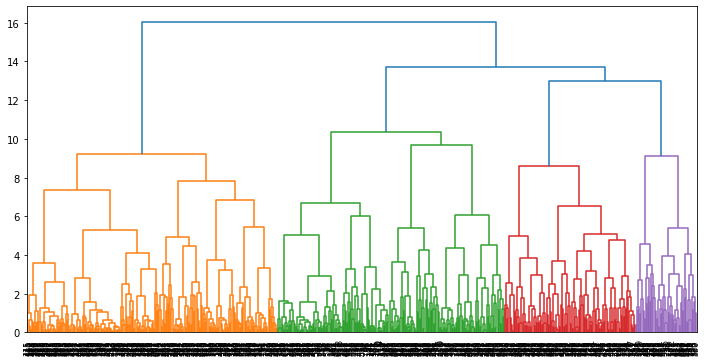

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix
Z = linkage(data, method='ward')

# plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

####  hyperparameter tuning
In my opinion, a value of 8 will be better choice of `distance_threshold` as the distance between the stages above and below 8 value become big.

Other hyperparameters:
- `linkage` : This parameter specifies the linkage criterion used to determine the distance between two clusters. I found `ward` as a good choice to have number of cluster within maximum 10.
- `affinity` : This parameter specifies the distance metric used to compute the pairwise distances between data points. I found `euclidean` as good choice in combunation of `ward`.

In [27]:
agglomerative_cluster = cluster.AgglomerativeClustering(n_clusters=None, linkage='ward', affinity='euclidean', distance_threshold=8.0)
agglomerative_cluster.fit(data)

best_n_clusters= agglomerative_cluster.n_clusters_
print("Optimal Number of Cluster (k): ", best_n_clusters)

Optimal Number of Cluster (k):  9


In [28]:
labels = agglomerative_cluster.labels_
cluster_center = np.zeros((best_n_clusters, data.shape[1]))
for i in range(best_n_clusters):
    mask = (labels == i)
    cluster_center[i, :] = data[mask, :].mean(axis=0)

#### Apply t-SNE
A t-SNE plot can be used to visualize high-dimensional data in a lower-dimensional space and can effectively highlight the cluster structure in the data. 

C:\Users\sneha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


transformation complete


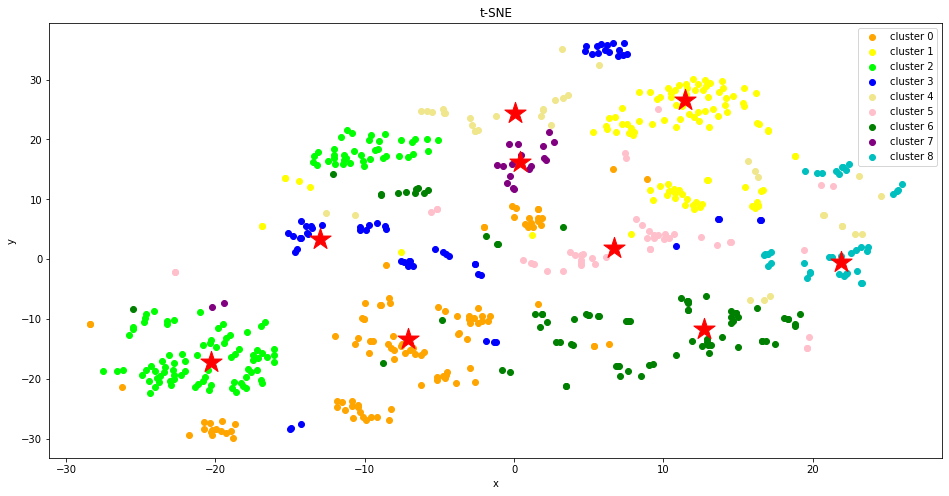

In [29]:
# Append the cluster centers to the dataset
data_and_centers = np.r_[data, cluster_center]

# Project both the data and the k-Means cluster centers to 2D.
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

clustering_scatterplot(points=XYcoordinates[:-best_n_clusters,:], 
                       labels=agglomerative_cluster.labels_,
                       centers=XYcoordinates[-best_n_clusters:,:], 
                       title='t-SNE')

#### Apply Locally Linear Embedding (LLE)
LLE is a nonlinear dimensionality reduction technique that can help in preserving the local structure of the data.

transformation complete


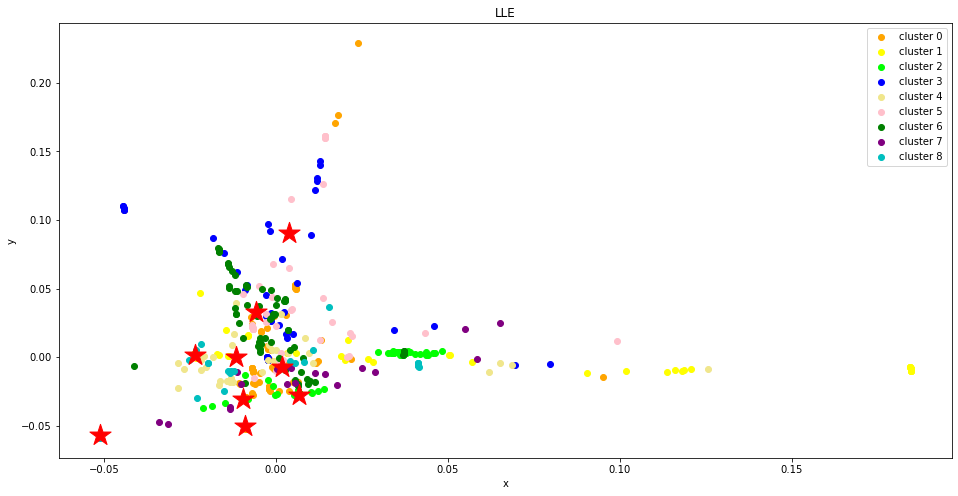

In [30]:
# Project both the data and the k-Means cluster centers to 2D.
XYcoordinates = manifold.LocallyLinearEmbedding(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

clustering_scatterplot(points=XYcoordinates[:-best_n_clusters,:], 
                       labels=agglomerative_cluster.labels_,
                       centers=XYcoordinates[-best_n_clusters:,:], 
                       title='LLE')

t-SNE seems to be performing better than LLE for plotting clustered data. This maybe because LLE tries to preserve the local structure of the data, which becomes increasingly difficult as the number of dimensions increases.

### K-Means Clustering vs Agglomerative clustering
##### Clustering technique
<b> K-Means Clustering </b> is a centroid-based algorithm that partitions the dataset into k non overlapping clusters, where each data sample belong to only one cluster. It iteratively assigns each data sample to its nearest cluster centroid and updating the centroid position based on the mean of the data points in that cluster. 

<b> Agglomerative Clustering </b> starts with each data point as a separate cluster and then merges the closest pairs of clusters based on a chosen linkage criterion (e.g. complete). This process continues until a stopping criterion is met (e.g., given number of clusters, distance threshold).

##### Clustering result comparison
When applied to the dataset provided, K-means clustering and Agglomerative clustering produced different clustering:
- Number of clusters are diferent  in K-Means clustering (8) and Agglomerative clustering(9).
- The Visualization of K-means clustering shows clusters with relatively dense shapes, while Agglomerative clustering produced more sparse and irregularly-shaped clusters. This is due to K-means clustering algorithm is based on minimizing the sum of the squared distances to the centroids, leading to circular clusters. But, Agglomerative clustering is based on the pairwise distances between points, which does not make any assumptions about the shape of the clusters and forms any shape.

- Another difference is that K-means clustering requires the number of clusters to be specified, while Agglomerative clustering does not. In the case of the given dataset, determining the optimal number of clusters is not straightforward, as various methods giving different cluster.

- Agglomerative Clustering is computationally more expensive than K-Means clustering and similarity criterias can affect quality of cluster. K-Means clustering is generally faster than Agglomerative clustering, especially when the dataset is large. Agglomerative clustering can be more accurate and robust in certain cases.